<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400100554
Name = 'Seyed Mohammad'
Last_Name = 'Ojagh Kazazi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [2]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
num_classes = len(train_set.classes)

# FashionMNIST images are 28x28 pixels
input_dim = 28 * 28

print("Number of classes: ", num_classes)
print("Input dimension for the first layer: ", input_dim)

Number of classes:  10
Input dimension for the first layer:  784


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

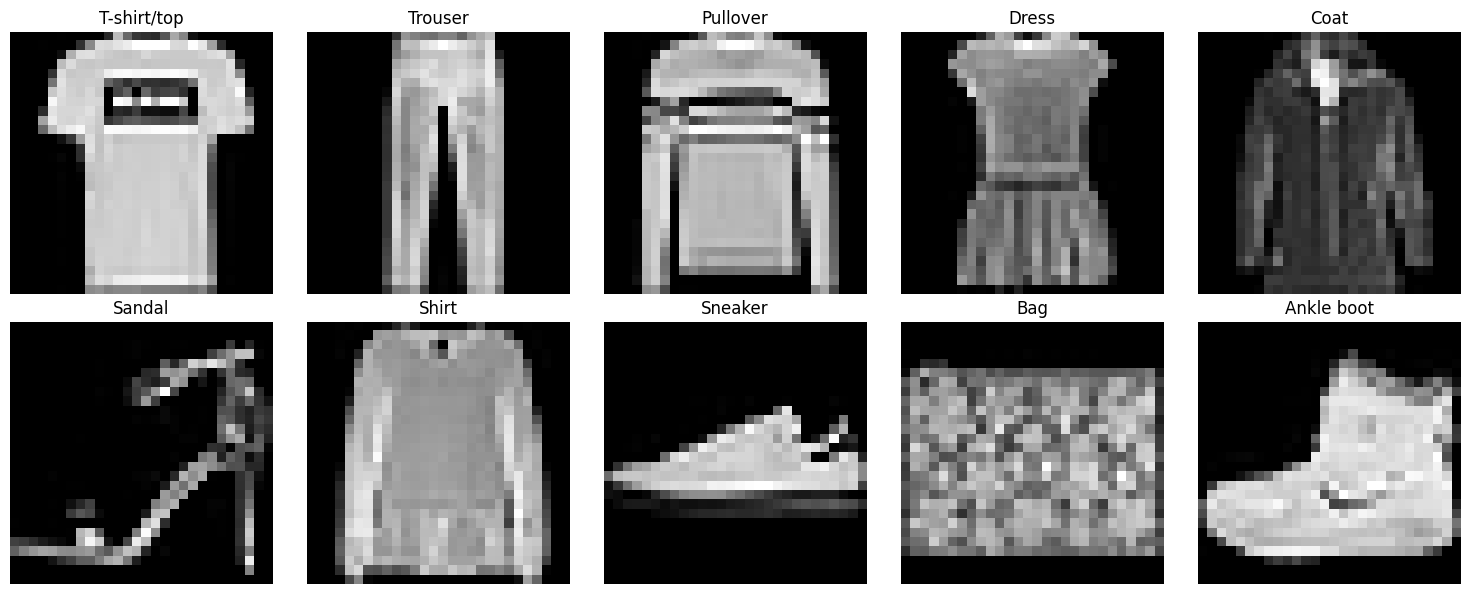

In [7]:

images_per_class = {class_name: None for class_name in train_set.classes} #create dintionary with class name as key and None as value


for image, label in train_set: # Iterate over the dataset until we have one image per class
    class_name = train_set.classes[label]
    if images_per_class[class_name] is None:
        images_per_class[class_name] = image
    if all(image is not None for image in images_per_class.values()):
        break

# Create a grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot one image per class
for ax, (class_name, image) in zip(axs.flatten(), images_per_class.items()):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    return x @ w + b

def relu(x):
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    for i in range(num_layers):
        weight = parameters[f'w{i}']
        bias = parameters[f'b{i}']
        x = affine_forward(x, weight, bias)
        
        if i < num_layers - 1:
            x = relu(x)
    
    output = x
    return output

Implementing cross entropy loss:

In [12]:
def cross_entropy_loss(scores, y):
    # Move scores and y to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scores = scores.to(device)
    y = y.to(device)

    # Compute the softmax for the scores
    exp_scores = torch.exp(scores - torch.max(scores, dim=1, keepdim=True)[0])
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    # Compute the cross-entropy loss
    correct_logprobs = -torch.log(probs[range(len(y)), y])
    loss = torch.sum(correct_logprobs) / len(y)

    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [13]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    
    # Update parameters using their gradients
    for param in parameters.values():
        if param.grad is not None:
            param.data -= learning_rate * param.grad.data
    
    # Zero the gradients of the parameters
    for param in parameters.values():
        if param.grad is not None:
            param.grad.zero_()


Training functions:

In [18]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct_predictions = np.sum(y_pred == y_true)
    total_predictions = len(y_true)
    acc = correct_predictions / total_predictions
    return acc



def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []


    for _, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        loss.backward()


        sgd_optimizer(parameters, learning_rate)
        train_loss += loss.item() * x.size(0)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    train_loss /= len(train_loader.dataset)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc




def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    
    for _, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Calculate the loss
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Epoch: {epoch}, {set_name} Loss: {total_loss}, Accuracy: {acc}')

    return total_loss, acc



In [19]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [20]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, 'Test')

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # plot the loss history of training and test sets 
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train')
    plt.plot(range(num_epochs), test_losses, label='Test')
    plt.title('Loss history')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot the accuracy history of training and test sets
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train')
    plt.plot(range(num_epochs), test_accuracies, label='Test')
    plt.title('Accuracy history')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Accuracy of train set: 0.5498166666666666
Epoch: 0, Test Loss: 0.030914480543136596, Accuracy: 0.4768
Accuracy of train set: 0.5153333333333333
Epoch: 1, Test Loss: 0.016372933101654052, Accuracy: 0.5734
Accuracy of train set: 0.6511333333333333
Epoch: 2, Test Loss: 0.013290368551015853, Accuracy: 0.6759
Accuracy of train set: 0.7026166666666667
Epoch: 3, Test Loss: 0.01208469604253769, Accuracy: 0.7234
Accuracy of train set: 0.7387
Epoch: 4, Test Loss: 0.01139704923927784, Accuracy: 0.7457
Accuracy of train set: 0.7637
Epoch: 5, Test Loss: 0.010405210518836975, Accuracy: 0.7609
Accuracy of train set: 0.7782833333333333
Epoch: 6, Test Loss: 0.009740231558680534, Accuracy: 0.7745
Accuracy of train set: 0.7906
Epoch: 7, Test Loss: 0.009675669431686401, Accuracy: 0.78
Accuracy of train set: 0.8034166666666667
Epoch: 8, Test Loss: 0.009070786771178245, Accuracy: 0.7904
Accuracy of train set: 0.8109
Epoch: 9, Test Loss: 0.008777222299575806, Accuracy: 0.8053
Accuracy of train set: 0.8185166

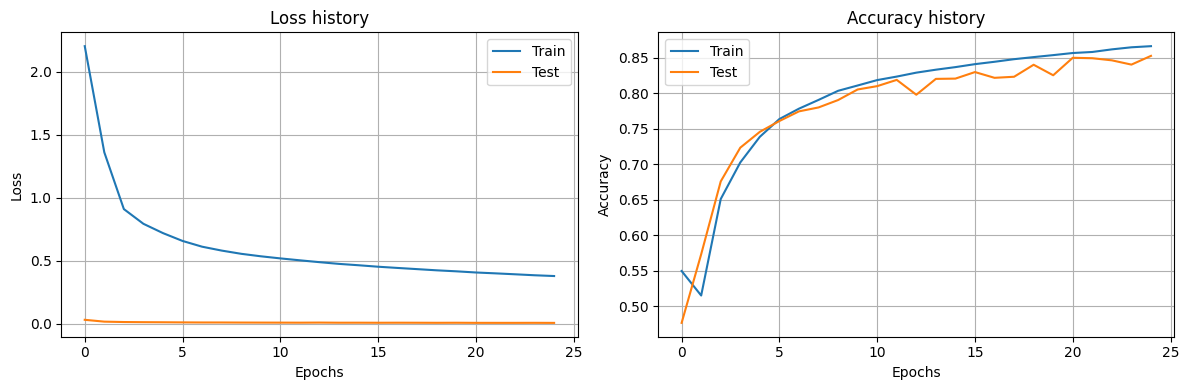

In [21]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [22]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8526


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

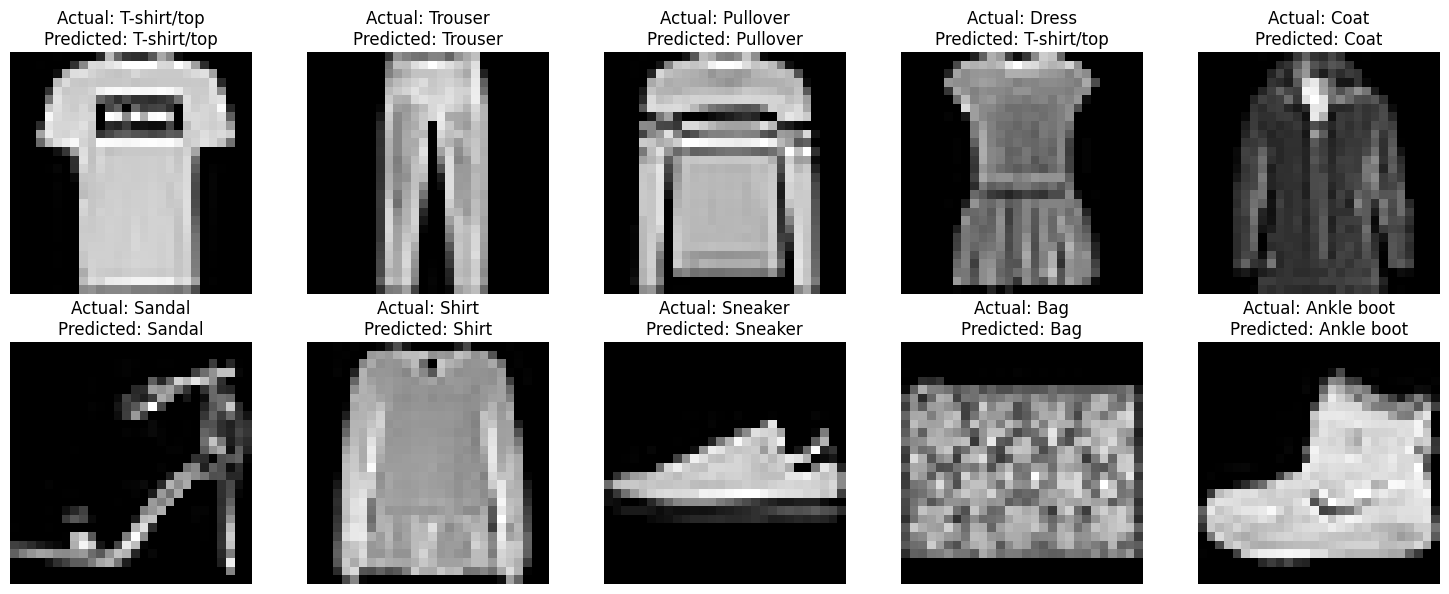

In [23]:
# Create a dictionary to store one image per class from the test set
images_per_class = {class_name: None for class_name in train_set.classes}

# Iterate over the dataset until we have one image per class
for image, label in train_set:
    class_name = train_set.classes[label]
    if images_per_class[class_name] is None:
        images_per_class[class_name] = (image, label)
    if all(img is not None for img in images_per_class.values()):
        break

# Convert the images to a tensor
class_images_tensor = torch.stack([img[0] for img in images_per_class.values()])

# Make predictions using the trained model
with torch.no_grad():
    class_predictions = model(class_images_tensor.to(device), parameters)

# Get the predicted labels
predicted_labels = torch.argmax(class_predictions, dim=1).cpu().numpy()

# Create a grid of subplots to plot the images with actual and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for ax, ((image, actual_label), predicted_label) in zip(axs.flatten(), zip(images_per_class.values(), predicted_labels)):
    class_name = train_set.classes[actual_label]
    predicted_class_name = test_set.classes[predicted_label]
    ax.imshow(image.permute(1, 2, 0).cpu(), cmap='gray')
    ax.set_title(f"Actual: {class_name}\nPredicted: {predicted_class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()
